### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
Start by importing all the required libraries

In [31]:
"""
Python 3.8
Tensorflow 2.3.1
Keras 2.4.3

wordcloud 1.8.0
"""
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import random as rnd
import numpy as np
import pandas as pd
import pickle
import os
import re
from keras.preprocessing.text import Tokenizer

# define constants
DATA_SET = "dataset/train.csv"
COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"


# Process dataset
### Read the dataset file and return a data frame


In [32]:
def process_dataset_Sentiment140(file_path: str ):
    # load the data file into a data frame
    df = pd.read_csv(file_path,encoding = 'latin',header=None)
    
    # Rename the columns so we can reference them later
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    
    # drop all the columns we don't need
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) 
    
    # change all 4's to 1's (just for neatness)
    df.loc[df['sentiment'] == 4, 'sentiment'] = 1
    
    # sort all the rows by the sentiment columns
    df.sort_values(by=['sentiment'])
    
    return df
    

### Read in the dataset file and show the first 5 rows of the data frame


In [33]:
data_frame = process_dataset_Sentiment140(DATA_SET)
data_frame.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 800,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

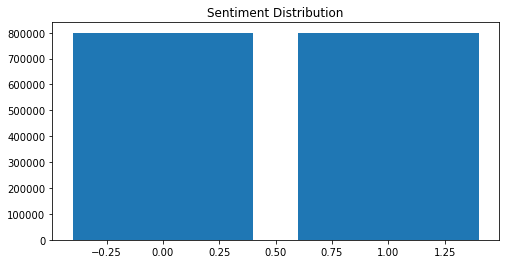

In [34]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

### We need to remove hyperlinks from the text - define a regex here to use

In [35]:
"""
preprocess-twitter.py

python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu (github.com/tokestermw)

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

light edits by amackcrane, mostly inspired by the test case given at bottom
"""
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()


# decided to use this regex instead of the above script
# we are using the glove 300d embeddings rather than the twitter glove embeddings
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9']+"

### Use the regex to clean all our text entries and write back to the data frame

In [36]:
def clean_text(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

In [37]:
data_frame.text = data_frame.text.apply(lambda x: clean_text(x))

In [38]:
data_frame.head()

,sentiment,text
0,0,awww that's a bummer you shoulda got david car...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am i h...


# Wordcloud of ```positive``` sentiments

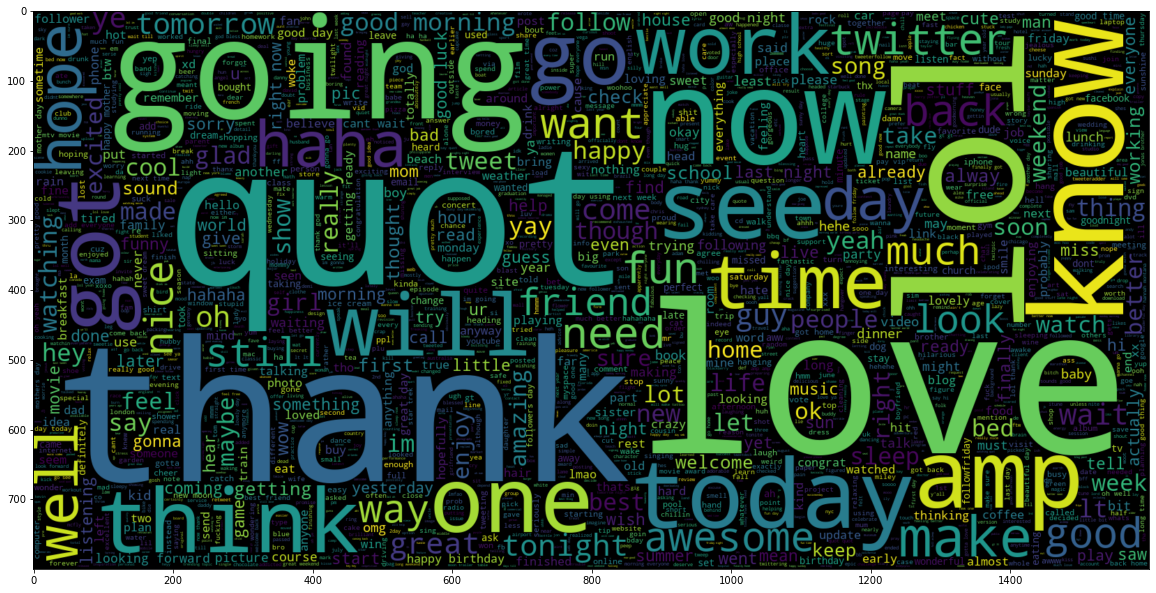

In [39]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# Wordcloud of ```negative``` sentiments

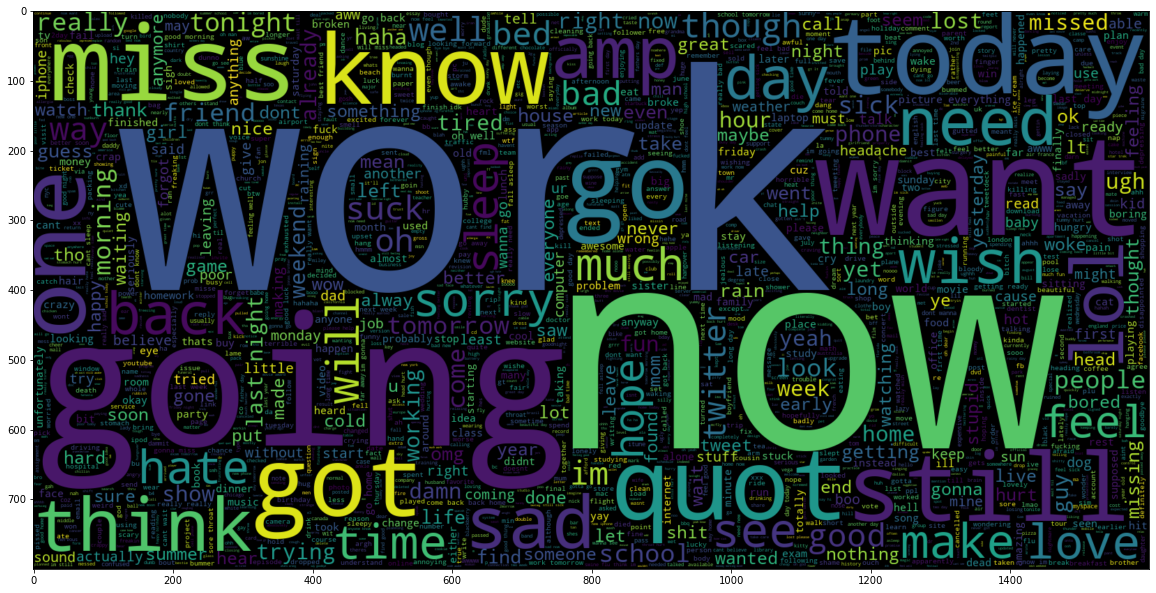

In [40]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Now we need randomise the dataset

In [46]:
data_frame = data_frame.sample(frac = 1, random_state =1) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 

In [47]:
data_frame.head()

,sentiment,text
198800,0,packing and listening to the stonkingly good f...
238408,0,i thought they already slimmed it down once to...
851333,1,i was indeed suffering on sunday but recovered...
296684,0,really don't feel well
34432,0,i got up early and i don't even have to


### Now we split the data set inot 80% for training and 20% for testing